In [17]:
# 连接数据库
import peewee
db = peewee.SqliteDatabase('hupu.db')
db.connect()

True

In [18]:
# 定义并创建模型
class Post(peewee.Model):
    class Meta:
        database = db
    pid = peewee.IntegerField()
    title = peewee.CharField()
    count_reply = peewee.IntegerField()
    count_view = peewee.IntegerField()
    status = peewee.IntegerField(default=0)

class Reply(peewee.Model):
    class Meta:
        database = db
    post = peewee.ForeignKeyField(Post, backref='replies')
    uid = peewee.IntegerField()
    create_time = peewee.DateTimeField()
    content = peewee.CharField()

class User(peewee.Model):
    class Meta:
        database = db
    uid = peewee.IntegerField()
    level = peewee.IntegerField()
    calorie = peewee.IntegerField()
    sports = peewee.CharField()
    teams = peewee.CharField()

Post.create_table()
Reply.create_table()
User.create_table()

In [ ]:
# 抓取主题列表
import requests as rq
from bs4 import BeautifulSoup
import time
posts = []
h = {
    'referer': 'https://bbs.hupu.com/bxj-postdate-1',
    'user-agent': 'Mozilla/5.0 Chrome/66.0',
    'cookie':"xxxxx", # 添加你的cookie，否则只能抓前几十页
}
for i in range(1, 160):
    print(i)
    url = 'https://bbs.hupu.com/bxj-postdate-' + str(i)
    r=rq.get(url, headers=h)
    r.encoding='utf8'
#     print(r.text)
    soup=BeautifulSoup(r.text, 'lxml')
    lis = soup.find(class_="show-list").find_all('li')
    for li in lis:
        title = li.a.text.lower()
        if '吴' in title or '凡' in title or 'skr' in title or 'diss' in title or 'rap' in title or 'hiphop' in title or '嘻哈' in title or 'wyf' in title or 'cris' in title or '51' in title:
            p = int(li.a.get('href').strip('/.html'))
            r, v = li.find(class_='ansour').text.split('/')
            r = int(r.strip())
            v = int(v.strip())
            Post.create(pid=p, title=title, count_reply=r, count_view=v)
#     time.sleep(1)

In [20]:
# 挑选部分帖子做后续分析
ps = Post.select().order_by(Post.count_reply.desc()).limit(100)
for p in ps:
    p.status = 1
    p.save()
ps = Post.select().order_by(peewee.fn.Random()).limit(100)
for p in ps:
    p.status = 1
    p.save()

In [21]:
# 抓取帖子中的回帖
import datetime

def get_page(post, page=1):
    print(page)
    pid = str(post.pid)
    if page == 1:
        url = 'https://bbs.hupu.com/%s.html' % pid
    else:
        url = 'https://bbs.hupu.com/%s-%d.html' % (pid, page)
    r = rq.get(url, headers=h)
    r.encoding = 'utf8'
#     print(r.content)
    t = r.text.replace('\r', '\n ')
    soup = BeautifulSoup(t, 'lxml')
    divs = soup.find_all(class_="floor-show")
    pages = 1
    if page == 1:
        # 第一页要抓取楼主的内容和页数
        try:
            first = divs[0]
            divs = divs[1:]
        except:
            print('================ERROR!:', pid)
            return
        # print(first)
        maxpages = soup.find(id="bbstopic_set")
        if maxpages:
            pages = int(maxpages.get('data-maxpage'))
        print(pages)
        uid = first.find('a', class_='u').get('href').split('/')[-1]
        ctime = datetime.datetime.strptime(first.find('span', class_='stime').text, '%Y-%m-%d %H:%M')
        content = first.find(class_='quote-content')
        foot = content.find('small')
        if foot:
            foot.extract()
        # print(content.text)
        content = content.text
        Reply.create(post=post, uid=uid, create_time=ctime, content=content)
        
    for div in divs[1:]:
        if div.td:
            foot = div.td.find('small')
            if foot:
                foot.extract()
            quote = div.td.find('blockquote')
            if quote:
                quote.extract()
            content = div.td.text
        else:
            print('================ERROR!:', pid)
            print(div)
            continue
        uid = div.find('a', class_='u').get('href').split('/')[-1]
        ctime = datetime.datetime.strptime(div.find('span', class_='stime').text, '%Y-%m-%d %H:%M')
#         print(uid, ctime, content)
        Reply.create(post=post, uid=uid, create_time=ctime, content=content)
    # 抓后续页
    for p in range(2, pages+1):
#         time.sleep(1)
        get_page(post, p)


In [ ]:
# get detail page
ps = Post.select().where(Post.status==1)
print(ps.count())
c = 1
for p in ps:
    print(c, p.pid, p.title)
    get_page(p)
    p.status = 2
    p.save()
    c += 1

In [ ]:
# 抓取用户详情页
import datetime
rs = Reply.select().order_by(peewee.fn.Random())
print(User.select().count())
c = 0
for rp in rs:
    c += 1
    print(c)
    if User.select().where(User.uid==str(rp.uid)).exists():
        continue
    url_u = 'https://my.hupu.com/%d/profile' % rp.uid
    r = rq.get(url_u, headers=h)
    r.encoding = 'utf8'
    t = r.text.replace('\r', '\n ')
    soup = BeautifulSoup(t, 'lxml')
    print(rp.uid)
    level = 0
    calorie = 0
    sports = ''
    teams = ''
    try:
        tables = soup.find_all(class_="profile_table")
        trs = tables[0].find_all('tr')
        for tr in trs:
            if '等级' in tr.text:
                level = tr.find_all('td')[1].text
            if '卡路里' in tr.text:
                calorie = tr.find_all('td')[1].text[:-3]
        trs = tables[1].find_all('tr')
        for tr in trs:
            if '运动' in tr.text:
                sports = tr.find_all('td')[1].text.strip()
                sports = sports.replace('\xa0', '')
            if '队伍' in tr.text:
                teams = tr.find_all('td')[1].text.strip()
                teams = teams.replace('\xa0', '')
        User.create(uid=rp.uid, level=level, calorie=calorie, sports=sports, teams=teams)
    except:
        print('===========ERROR:', rp.uid)
        continue
#     time.sleep(1)


In [26]:
# 统计数据
print('总帖数', Post.select().count())
pv = Post.select(peewee.fn.Sum(Post.count_reply).alias('r'))
print('总回帖数', pv[0].r)
pv = Post.select(peewee.fn.Sum(Post.count_view).alias('v'))
print('总浏览量', pv[0].v)

print('抽样回帖数', Reply.select().count())
print('抽样用户数', User.select().count())

print('最早回复', Reply.select().order_by(Reply.create_time).limit(1)[0].create_time)
print('最晚回复', Reply.select().order_by(Reply.create_time.desc()).limit(1)[0].create_time)

print('最高等级', User.select().order_by(User.level.desc()).limit(1)[0].level)
print('最高卡路里', User.select().order_by(User.calorie.desc()).limit(1)[0].calorie)

总帖数 4773
总回帖数 261570
总浏览量 126247622
抽样回帖数 137161
抽样用户数 5279
最早回复 2018-07-25 15:06:00
最晚回复 2018-08-02 16:24:00
最高等级 231
最高卡路里 561278


In [9]:
list_reply = [0 for x in range(24 * 9)]
list_reply_day = [[0 for x in range(24)] for y in range(9)]
start = datetime.datetime.strptime('2018-07-25', '%Y-%m-%d')
rs = Reply.select()#.limit(1000)
for r in rs:
    delta_day = r.create_time - start
    hours = int(delta_day.total_seconds()) // 60 // 60
    list_reply[hours] += 1
    hours_day = delta_day.seconds // 60 // 60    
    list_reply_day[delta_day.days][hours_day] += 1

    

In [10]:
import pyecharts as ec
list_hours = [(start + datetime.timedelta(hours=x)).strftime('%m.%d %H') for x in range(0, 24 * 9)]
line = ec.Line('时间统计', width=1000)
line.add("回帖", list_hours, list_reply, xaxis_interval=3, xaxis_rotate=-90)
line

In [14]:
line = ec.Line('每日回帖时间统计', width=1000)
hours = list(range(24))
for i in range(9):
    day = (start + datetime.timedelta(days=i)).strftime('%m.%d')
    line.add(day, hours, list_reply_day[i], is_stack=True, is_fill=True, area_opacity=0.5, xaxis_rotate=-90)
line

In [445]:
list_level = [0 for x in range(101)]
list_calorie = [0 for x in range(-1, 21)]
us = User.select()#.limit(100)
for u in us:
    l = min(100, u.level)
    list_level[l] += 1
    c = max(-1, min(20, u.calorie//10))
    list_calorie[c+1] += 1
list_calorie


[349,
 618,
 2590,
 278,
 162,
 131,
 87,
 73,
 57,
 46,
 41,
 49,
 49,
 38,
 18,
 23,
 22,
 25,
 20,
 22,
 22,
 559]

In [478]:
bar = ec.Bar(width=1000)
levels = list(range(100))
levels.append('≥100')
bar.add('等级', levels, list_level)
bar

In [477]:
list_calorie
bar = ec.Bar(width=1000)
calories = ['<0']
calories += [i * 10 for i in (range(20))]
calories.append('≥200')
bar.add('卡路里', calories, list_calorie)
bar

In [16]:
sct = ec.Scatter(width=1000, height=600)
list_level = []
list_calorie = []
us = User.select()
for u in us:
    list_level.append(u.level)
    list_calorie.append(max(min(u.calorie, 25000), -5000))
sct.add('用户', list_level, list_calorie, symbol_size=5, xaxis_name='等级', yaxis_name='卡路里')
sct

In [490]:
us = User.select()
sports = {}
teams = {}
for u in us:
    ss = u.sports.split()
    for s in ss:
        sports[s] = sports.get(s, 0) + 1
    ts = u.teams.split()
    for t in ts:
        teams[t] = teams.get(t, 0) + 1
print(sports)
print(teams)

{'NFL美式橄榄球': 25, '棋牌': 39, '美式橄榄球': 60, '台球/斯诺克': 107, '足球': 560, '运动装备': 537, '篮球': 1717, '跳水': 22, '田径': 78, '棒球': 21, '英式橄榄球': 7, '篮彩': 31, '网球': 126, 'Motogp': 9, 'NBA游戏': 291, '足彩': 20, '极限运动': 70, 'F1赛车': 86, '跑步': 144, '乒乓球': 72, '羽毛球': 101, '游泳': 126, 'WRC/拉力赛': 23, '台球': 27}
{'利物浦': 60, '克罗地亚(世界杯)': 4, '南安普顿': 1, '英格兰(欧洲杯)': 5, '北京国安': 14, '休斯顿德州人': 2, '澳大利亚(世界杯)': 4, '美国(世界杯)': 2, '武汉卓尔': 2, '水晶宫': 3, '芝加哥熊': 1, '葡萄牙(欧洲杯)': 4, '延边富德': 1, '辽宁宏远': 1, '福建中华鲟': 13, '尤文图斯': 45, '法国(世界杯)': 22, '那不勒斯': 9, '纽约尼克斯': 98, '上海申花': 14, '广州富力': 3, '小红牛': 1, '哥伦比亚(世界杯)': 5, '波特兰开拓者': 54, '天津金狮': 1, '阿尔及利亚(世界杯)': 2, '俄罗斯(欧洲杯)': 1, '巴黎圣日耳曼': 23, '河南四五': 1, '勒沃库森': 3, '巴尔的摩乌鸦': 1, '佛山龙狮': 3, '浙江金牛': 4, '长春亚泰': 2, '北京鸭': 51, 'RB莱比锡': 3, '斯托克城': 3, '洛杉矶湖人': 455, '浙江广厦猛狮': 18, '沃尔夫斯堡': 7, '丹佛掘金': 41, '拜仁慕尼黑': 95, '马赛': 5, 'AC米兰': 70, '卡塔尼亚': 1, '日本(世界杯)': 8, '皇家马德里': 138, '布莱克本': 1, '皇家贝蒂斯': 2, '西汉姆': 3, '曼联': 125, '迈阿密海豚': 2, '广东华南虎': 81, '贵州智诚': 1, '塞尔塔': 1, '门兴': 3, '波黑(世界杯)': 2, '夏洛特山猫': 6, '

In [36]:
from collections import Counter, OrderedDict
teams_most = OrderedDict(Counter(teams).most_common(40))
teams_most['其他'] = sum(teams.values()) - sum(teams_most.values())
print(teams_most)
pie = ec.Pie(width=1000)
pie.add('队伍', teams_most.keys(), teams_most.values(), is_legend_show=False, is_label_show=True)
pie

OrderedDict([('洛杉矶湖人', 455), ('休斯顿火箭', 404), ('克利夫兰骑士', 324), ('金州勇士', 301), ('圣安东尼奥马刺', 299), ('波士顿凯尔特人', 235), ('俄克拉荷马城雷霆', 216), ('迈阿密热火', 204), ('洛杉矶快船', 163), ('皇家马德里', 138), ('芝加哥公牛', 134), ('曼联', 125), ('巴塞罗那', 113), ('阿森纳', 99), ('纽约尼克斯', 98), ('拜仁慕尼黑', 95), ('费城76人', 94), ('广东华南虎', 81), ('切尔西', 80), ('达拉斯小牛', 80), ('明尼苏达森林狼', 80), ('AC米兰', 70), ('广州恒大', 66), ('利物浦', 60), ('菲尼克斯太阳', 59), ('德国(世界杯)', 58), ('波特兰开拓者', 54), ('布鲁克林篮网', 54), ('印第安纳步行者', 53), ('北京鸭', 51), ('华盛顿奇才', 47), ('辽宁飞豹', 47), ('尤文图斯', 45), ('孟菲斯灰熊', 43), ('多特蒙德', 43), ('丹佛掘金', 41), ('巴西(世界杯)', 41), ('曼城', 40), ('新奥尔良鹈鹕', 39), ('底特律活塞', 38), ('其他', 1281)])


In [37]:
s = sorted(sports.items(), key=lambda x: x[1], reverse=True)
s = OrderedDict(s)
pie = ec.Pie(width=1000)
pie.add('运动', s.keys(), s.values(), is_legend_show=False, is_label_show=True)
pie

In [ ]:
# 分词，统计词频
import jieba
words = {}
rs = Reply.select().order_by(Reply.id)
print(rs.count())
c = 0
jieba.add_word('虎扑')
jieba.add_word('skr')
jieba.add_word('jrs')
jieba.add_word('hupu')
jieba.add_word('哈哈')
for r in rs:
    c += 1
    if c % 1000 == 0:
        print(c)
    ws = jieba.cut(r.content.lower())
    for w in ws:
        words[w] = words.get(w, 0) + 1

to_d = []
for i in words:
    if words[i] < 1000:
        to_d.append(i)
for k in to_d:
    del words[k]
words

In [41]:
ws = OrderedDict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:300])
for i in ['又', '一', '想', '会', '完', '这是', '怎么', '你', '?', '\n', '只', '/', '才', '和',
          '叫', '给', '找', '”', '在', '被', '事', ':', '...', '点', '可能', '）', '、', '她', '不', '：', '做', '!',
          '然后', '为', '的', '都', '的话', '～', '…', '这个', '以为', '过', '再', '这', '看', '个', '看到', '打', '很',
          '“', '最', '小', '能', '不要', '已经', '去', '人', '不能', '是', '起来', '们', '走', '，', '来', '出', '那个',
          '\xa0', '了', '也', '就', '一下', '很多', '-', '就是', '今天', '到', '一起', '这些', '（', '什么', '下',
          '其实', '写', '没有', '.', '当', '。', '啦', '把', '那么', '开始', '但是', ',', '吧', '那些', '这种', '上',
          '他们', '更', '最后', '嘛', 'ar', '要', '不会', '靠', '吗', '还是', '着', '这么', '对', '这样',
          ' ', '~', '多', '他', '没', '我', '可以', '一个', '因为', '是不是', '所以', '但', '太', '用', '里',
          '你们', '跟', '我们', '！', '虽然', '应该', '一点', '知道', '好', '时候', '么', '得', '那', '呢', '有',
          '还有', '自己', '啊', '觉得', '谁', '还', '不是', '像', '*', '？']:
    del ws[i]
ws

OrderedDict([('skr', 93381),
             ('说', 12853),
             ('虎扑', 11273),
             ('吴亦凡', 9189),
             ('真的', 7016),
             ('diss', 5306),
             ('哈哈哈', 4996),
             ('粉丝', 4787),
             ('听', 4548),
             ('完事', 4381),
             ('水平', 3845),
             ('说唱', 3717),
             ('凡', 3441),
             ('让', 3364),
             ('中国', 3286),
             ('现在', 3181),
             ('凡凡', 3113),
             ('jrs', 3108),
             ('喜欢', 3024),
             ('jr', 2815),
             ('比', 2813),
             ('黑', 2805),
             ('逼', 2659),
             ('感觉', 2617),
             ('出来', 2526),
             ('😂', 2465),
             ('楼主', 2439),
             ('啥', 2408),
             ('唱', 2344),
             ('哈哈', 2198),
             ('真', 2173),
             ('有点', 2149),
             ('兄弟', 2139),
             ('wyf', 2119),
             ('实力', 2075),
             ('笑', 1988),
             ('一样', 1982),
   

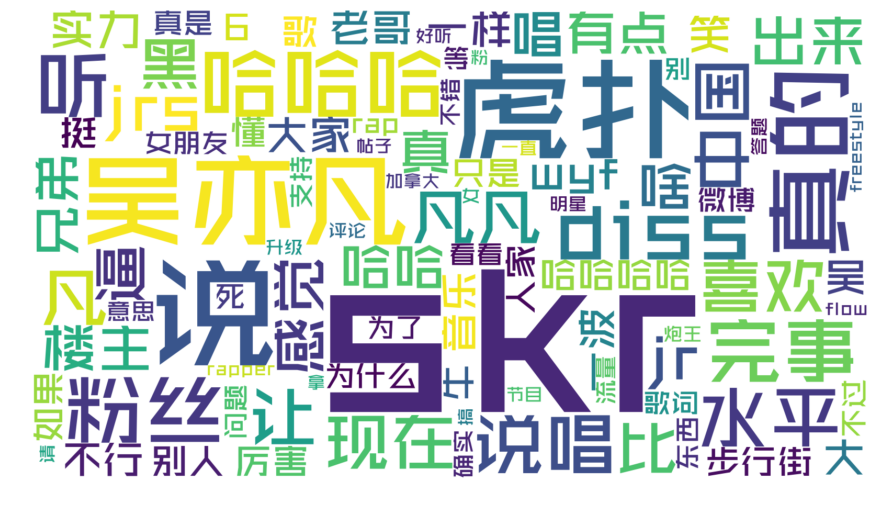

In [46]:
from wordcloud import WordCloud
wc = WordCloud(
    font_path='../zhaozi.ttf',
    background_color='white',
    width=1600,
    height=900,
    random_state=100,
)
c = wc.generate_from_frequencies(ws)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
ax.imshow(c, interpolation='bilinear')
plt.axis("off")
plt.show()

In [667]:
records = []
results = []

In [ ]:
# 通过腾讯AI接口进行情感分析
import random, string, urllib, hashlib

APPKEY = 'xxxx' #换成你的腾讯AI appkey
APPID = 123456789 #换成你的腾讯AI appid
url_nlp = 'https://api.ai.qq.com/fcgi-bin/nlp/nlp_textpolar'

def get_sign(data):
    lst = [i[0]+'='+urllib.parse.quote_plus(str(i[1])) for i in data.items()]
    params = '&'.join(sorted(lst))
    s = params + '&app_key=' + APPKEY
    h = hashlib.md5(s.encode('utf8'))
    return h.hexdigest().upper()

c = 0
rs = Reply.select().order_by(peewee.fn.Random()).limit(1)
for r in rs:
    c += 1
    if r.id in records:
        print('already........', r.id)
        continue
    print(c, r.id)
    records.append(r.id)
    nonce_str = ''.join(random.sample(string.ascii_letters + string.digits, 16))
    data = {
        'app_id': APPID,
        'time_stamp': int(time.time()),
        'nonce_str': nonce_str,
        'text': r.content
    }
    data['sign'] = get_sign(data)
    rsp = rq.post(url_nlp, data=data)
    result = rsp.json()['data']
#     print(result)
    if result['confd'] == 0:
        print(rsp.json(), r.content)
    else:
        results.append(result)
    time.sleep(1)

In [741]:
import math
list_nlp = [0 for x in range(21)]
for r in results:
    s = int(r['confd'] * r['polar'] * 10)
    list_nlp[s + 10] += 1

# 为了显示效果，把中性数据高度降低
list_nlp[10] /= 5
    
bar = ec.Bar(width=1000)
nlp = list(range(-10, 11))
zeros = [0 for x in range(10)]
bar.add('正面', nlp, zeros + [0] + list_nlp[11:], is_stack=True)
bar.add('负面', nlp, list_nlp[:10] + [0] + zeros, is_stack=True)
bar.add('中性', nlp, zeros + list_nlp[10:11] + zeros, is_stack=True)
bar